In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.utils as np_utils
import tensorflow as tf

from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from PIL import Image, ImageFile 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D # Not using in Transfer Learning
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

In [2]:
# Relevant paths
devkit_path = Path("/media/Data/grabai/car_devkit/devkit")
train_path = Path("/media/Data/grabai/cars_train")
test_path = Path("/media/Data/grabai/cars_test")

In [3]:
# Load labels
cars_meta = loadmat(devkit_path/"cars_meta.mat")

# Create labels dataframe
cars_info = pd.DataFrame([i[0] for i in cars_meta["class_names"][0]], columns=["class_names"])

# First 5 rows
cars_info.head()

,class_names
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [4]:
# Load training info
cars_train_annos = loadmat(devkit_path/"cars_train_annos.mat")

# create training info dataframe
data = [[i.flat[0] for i in row] for row in cars_train_annos["annotations"][0]]
columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id", "fname"]
train_info = pd.DataFrame(data, columns=columns)

# Update class values since Python index starts from 0
train_info["class_id"] -= 1

# Append train_path to fname
train_info["fname"] = [train_path/f for f in train_info["fname"]]

# Merge labels
train_info = train_info.merge(cars_info, how="inner", left_on="class_id", right_index=True)
train_info = train_info.sort_index()

# First 5 rows
train_info.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,fname,class_names
0,39,116,569,375,13,/media/Data/grabai/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,/media/Data/grabai/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,/media/Data/grabai/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,/media/Data/grabai/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,/media/Data/grabai/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


In [5]:
# Load test info with labels
cars_test_annos_withlabels = loadmat(devkit_path/"cars_test_annos_withlabels.mat")

# create test info dataframe
data = [[i.flat[0] for i in row] for row in cars_test_annos_withlabels["annotations"][0]]
columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id", "fname"]
test_info = pd.DataFrame(data, columns=columns)

# Update class values since Python index starts from 0
test_info["class_id"] -= 1

# Append test_path to fname
test_info["fname"] = [test_path/f for f in test_info["fname"]]

# Merge labels
test_info = test_info.merge(cars_info, how="inner", left_on="class_id", right_index=True)
test_info = test_info.sort_index()

# First 5 rows
test_info.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,fname,class_names
0,30,52,246,147,180,/media/Data/grabai/cars_test/00001.jpg,Suzuki Aerio Sedan 2007
1,100,19,576,203,102,/media/Data/grabai/cars_test/00002.jpg,Ferrari 458 Italia Convertible 2012
2,51,105,968,659,144,/media/Data/grabai/cars_test/00003.jpg,Jeep Patriot SUV 2012
3,67,84,581,407,186,/media/Data/grabai/cars_test/00004.jpg,Toyota Camry Sedan 2012
4,140,151,593,339,184,/media/Data/grabai/cars_test/00005.jpg,Tesla Model S Sedan 2012


In [6]:
# Check distributions of labels in the training dataset


100%|██████████| 3/3 [00:00<00:00,  9.55it/s]


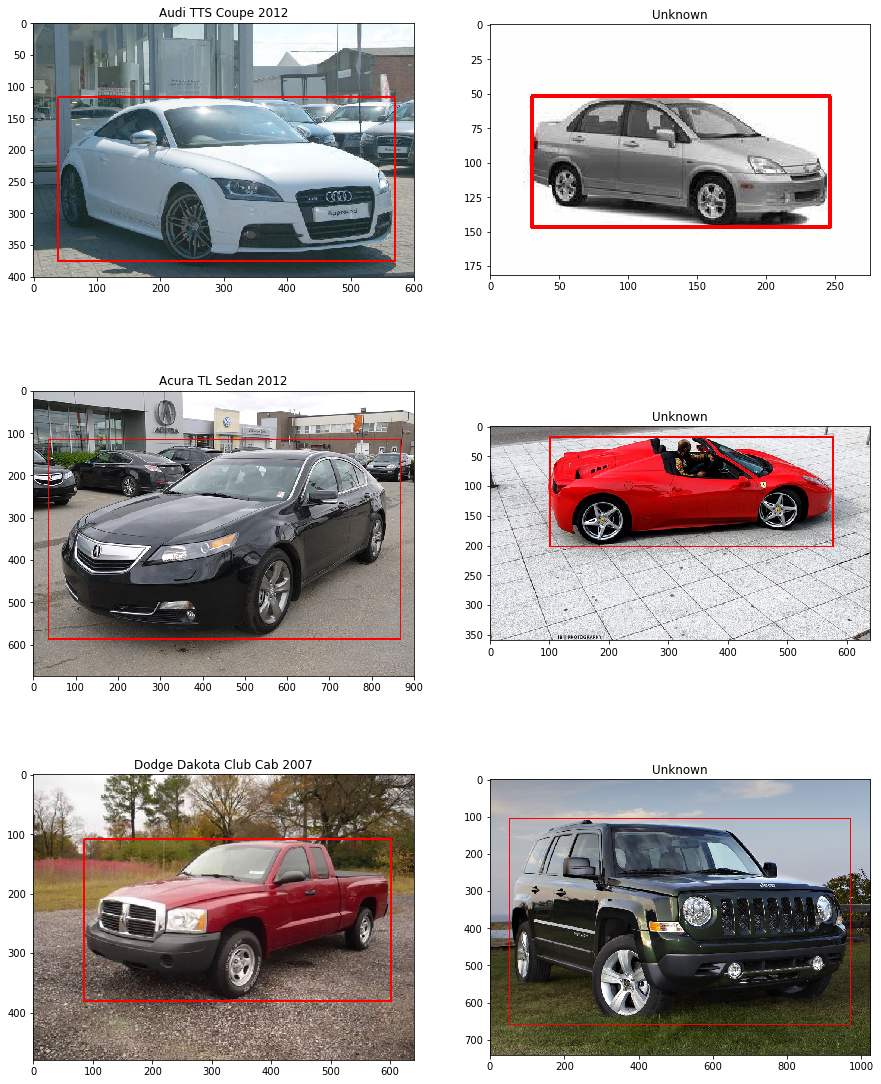

In [7]:
# The function below returns an image and corresponding label at position i from train_info or test_info dataframe 
# for plotting.
# Arg(s):
#     df (pandas.core.frame.DataFrame): train_info or test_info dataframe
#     i (int): element i in the dataframe.
def get_image_info(df, i):
    # Get relevant informations from df.loc[i]
    x1 = df["bbox_x1"][i]
    y1 = df["bbox_y1"][i] 
    x2 = df["bbox_x2"][i] 
    y2 = df["bbox_y2"][i]
    image_path = df["fname"][i]
    title = df["class_names"][i] if (df is train_info) else "Unknown"
    
    # Load colour (BGR) image
    img = cv2.imread(str(image_path))
    
    # Add bounding box to the image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), thickness=2)
    
    # Convert BRG image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return cv_rgb, title

# Draw first 3 images from training set and test set
fig, ax = plt.subplots(3, 2, figsize=(15,20))
for i in tqdm(range(3)):
    # Draw image from training set
    cv_rgb, title = get_image_info(train_info, i)
    ax[i, 0].imshow(cv_rgb)
    ax[i, 0].set_title(title)
    
    # Draw image from test set
    cv_rgb, title = get_image_info(test_info, i)
    ax[i, 1].imshow(cv_rgb)
    ax[i, 1].set_title(title)

plt.show()

In [26]:
INPUT_SHAPE=(256, 256, 3)
TARGET_SIZE=(256, 256)
BATCH_SIZE=32
EPOCHS=25
LR=0.0001

In [9]:
# Keras CNN requires a 4D array as input with shape (batch, rows, cols, channels)
# The function below takes a list of string-valued file paths to colour images and return a 4D tensor for Keras CNN
# Arg(s):
#     image_paths: string-valued file paths to colour images
def prepare_tensors(image_paths):
    tensors = []
    for _, image_path in enumerate(tqdm(image_paths)):
        # Load RGB image as PIL.Image.Image type
        img = image.load_img(image_path, target_size=TARGET_SIZE)
        
        # Convert PIL.Image.Image type to 3D tensor with shape TARGET_SIZE
        # Rescale the RGB coefficients from range (0, 255) to range (0,1)
        x = image.img_to_array(img)/255.0
        
        # Convert 3D tensor to 4D tensor
        tensors.append(np.expand_dims(x, axis=0))
    return np.vstack(tensors)

In [10]:
X, y = train_info["fname"], train_info["class_id"]

# Stratify parameter is set to ensure that the train and test sets have approximately the same percentage of 
# samples of each target class as the complete set.
# Split training set into training, validation, and test sets (70%, 15%, 15% respectively)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=np.array(y), 
                                                    random_state=40)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                      stratify=np.array(y_test), 
                                                      random_state=40)

# One-hot encoding the classes
N_CLASSES = cars_info.size # 196 classes of cars
y_train = np_utils.to_categorical(y_train, N_CLASSES)
y_test = np_utils.to_categorical(y_test, N_CLASSES)
y_valid = np_utils.to_categorical(y_valid, N_CLASSES)

In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_tensors = prepare_tensors(X_train).astype("float32")
valid_tensors = prepare_tensors(X_valid).astype("float32")
test_tensors = prepare_tensors(X_test).astype("float32")

100%|██████████| 1222/1222 [00:25<00:00, 47.96it/s]


In [12]:
print(train_tensors.shape[0], "training samples")
print(valid_tensors.shape[0], "validation samples")
print(test_tensors.shape[0], "test samples")

5700 training samples
1222 validation samples
1222 test samples


In [13]:
# Image preprocessing and augmentation
# Train generator
train_datagen = ImageDataGenerator(
                    rotation_range=30, # Randomly rotate image
                    width_shift_range=0.2, # Randomly translate image horizontally
                    height_shift_range=0.2, # Randomly translate image vertically
                    # shear_range=0.2, # Randomly apply shearing transformations
                    # zoom_range=0.2, # Randomly zooming inside image
                    # vertical_flip=True, # Randomly flip image vertically
                    horizontal_flip=True) # Randomly flip image horizontally

# Fit augmented image generator on data
train_datagen.fit(train_tensors)

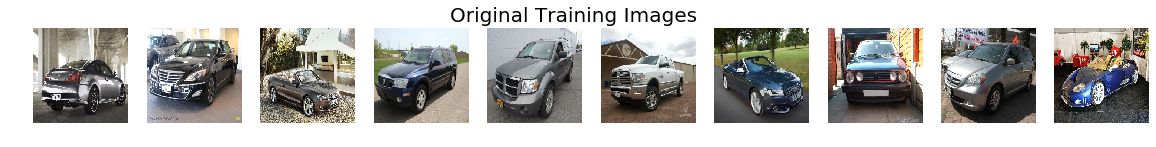

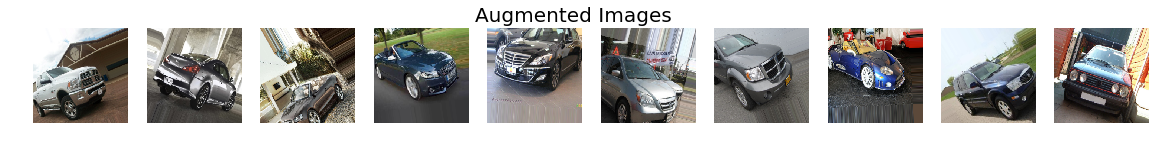

In [14]:
# Visualise images from training dataset
IMAGES=10 # Pick 10 images to show

fig = plt.figure(figsize=(20,2))
for i in range(IMAGES):
    ax = fig.add_subplot(1, IMAGES, i+1)
    ax.imshow(train_tensors[i])
    ax.axis("off")
fig.suptitle("Original Training Images", fontsize=20)
plt.show()

# Visualise augmented images
fig = plt.figure(figsize=(20,2))
for train_batch in train_datagen.flow(train_tensors[:IMAGES], batch_size=IMAGES):
    for i in range(IMAGES):
        ax = fig.add_subplot(1, IMAGES, i+1)
        ax.imshow(train_batch[i])
        ax.axis("off")
    fig.suptitle("Augmented Images", fontsize=20)
    plt.show()
    break;

## CNN Model Architecture
- Load InceptionV3 preptrained on ImageNet without its classification layer.
- Add custom layers on top of the base model to prepare custom classifer.

In [27]:
tf.keras.backend.clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

In [28]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

In [30]:
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(1024, activation="relu")(out)
predictions = Dense(N_CLASSES, activation="softmax")(out)

In [31]:
model = Model(inputs=base_model.input, outputs=predictions)

## Compile the Model

In [32]:
# Freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=LR), metrics=["accuracy"])

# View model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

## Train the Model

In [33]:
#Validation generator
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(valid_tensors, y_valid, shuffle=False, batch_size=BATCH_SIZE)

# train the model
checkpointer = ModelCheckpoint(filepath="grabai_cars.weights.best.hdf5", verbose=1, save_best_only=True)
history = model.fit_generator(train_datagen.flow(train_tensors, y_train, shuffle=False, batch_size=BATCH_SIZE),
                    steps_per_epoch=train_tensors.shape[0] // BATCH_SIZE,
                    epochs=EPOCHS, verbose=1, callbacks=[checkpointer],
                    validation_data=valid_generator,
                    validation_steps=valid_tensors.shape[0] // BATCH_SIZE)

Epoch 1/25
39/39 [==============================] - 4s 97ms/step - loss: 5.1682 - acc: 0.0139

Epoch 00001: val_loss improved from inf to 5.16821, saving model to grabai_cars.weights.best.hdf5
179/179 [==============================] - 79s 440ms/step - loss: 5.2999 - acc: 0.0084 - val_loss: 5.1682 - val_acc: 0.0139
Epoch 2/25
39/39 [==============================] - 3s 73ms/step - loss: 4.9909 - acc: 0.0336

Epoch 00002: val_loss improved from 5.16821 to 4.99091, saving model to grabai_cars.weights.best.hdf5
179/179 [==============================] - 60s 337ms/step - loss: 5.1465 - acc: 0.0223 - val_loss: 4.9909 - val_acc: 0.0336
Epoch 3/25
39/39 [==============================] - 3s 73ms/step - loss: 4.8736 - acc: 0.0360

Epoch 00003: val_loss improved from 4.99091 to 4.87358, saving model to grabai_cars.weights.best.hdf5
179/179 [==============================] - 61s 340ms/step - loss: 4.9654 - acc: 0.0423 - val_loss: 4.8736 - val_acc: 0.0360
Epoch 4/25
39/39 [=======================

In [34]:
# Load the weights that yielded the best validation accuracy
model.load_weights("grabai_cars.weights.best.hdf5")

In [35]:
# Evaluate and print test accuracy
score = model.evaluate(test_tensors, y_test, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 0.08674304


## Model Performance

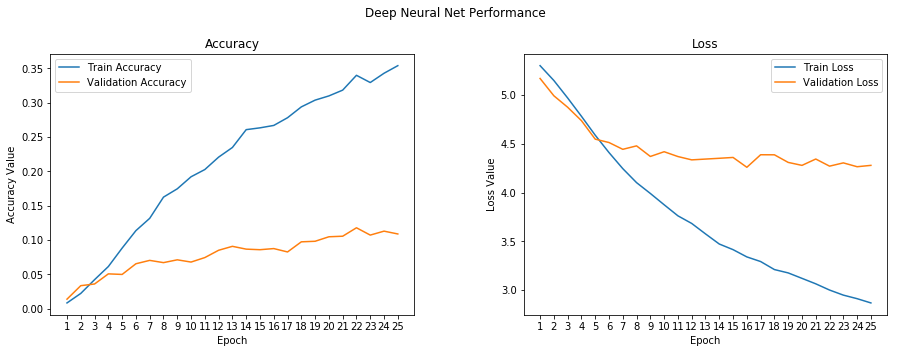

In [36]:
# Need to update
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle("Deep Neural Net Performance", fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,(EPOCHS+1)))
ax1.plot(epochs, history.history["acc"], label="Train Accuracy")
ax1.plot(epochs, history.history["val_acc"], label="Validation Accuracy")
ax1.set_xticks(epochs)
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history["loss"], label="Train Loss")
ax2.plot(epochs, history.history["val_loss"], label="Validation Loss")
ax2.set_xticks(epochs)
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc="best")